In [49]:
from koselleck import *
absw=get_words_ever_abs()

DF=df=pd.read_pickle(FN_DATA_PACEOFCHANGE).reset_index()
df

,word,dist,is_clean,period1,period2
0,abbe,0.560645,False,1700-1705,1705-1710
1,abbey,0.691516,False,1700-1705,1705-1710
2,abbot,0.369839,True,1700-1705,1705-1710
3,abdication,0.743533,False,1700-1705,1705-1710
4,abhorrence,0.753346,False,1700-1705,1705-1710
...,...,...,...,...,...
3507627,zest,0.450700,True,1890-1895,1895-1900
3507628,zinc,0.194274,True,1890-1895,1895-1900
3507629,zone,0.444468,True,1890-1895,1895-1900
3507630,zoo,0.362270,True,1890-1895,1895-1900


In [50]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import csv, random
import numpy as np
from scipy import spatial
extent=[1700,1900, 1700,1900]
FOOTE_W=5
NUM=100

In [51]:
# plt.rcParams["figure.figsize"] = [9.0, 6.0]
# plt.matshow(distdf, origin = 'lower', cmap = plt.cm.YlOrRd, extent = extent)
# plt.show()

In [52]:
def plot_distmat(distdf):
    plt.rcParams["figure.figsize"] = [9.0, 6.0]
    plt.matshow(distdf, origin = 'lower', cmap = plt.cm.YlOrRd, extent = extent)
    plt.show()

In [53]:
@interact
def showdistmat(w='critique'):
    try:
        distdf=get_distmatrix_rateofchange(DF, words={w})
        plot_distmat(distdf)
    except Exception as e:
        print(e)
        pass

interactive(children=(Text(value='critique', description='w'), Output()), _dom_classes=('widget-interact',))

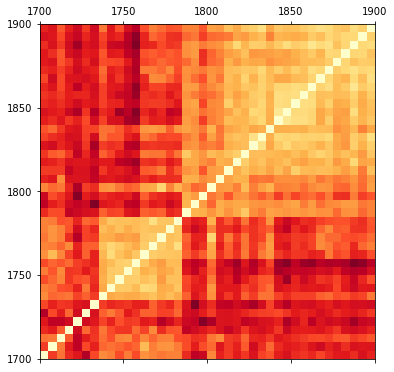

In [14]:
# d=distdf=get_distmatrix_rateofchange(DF, words=None)#'interest'})
d=distdf=get_distmatrix_rateofchange(DF, words={'slave'})
dq=d.values
plot_distmat(distdf)

In [15]:
# novelties = foote_novelty(distdf)
# plt.plot(getyears(), novelties)
# plt.show()
# print("Max novelty for a five-year half-width: " + str(np.max(novelties)))

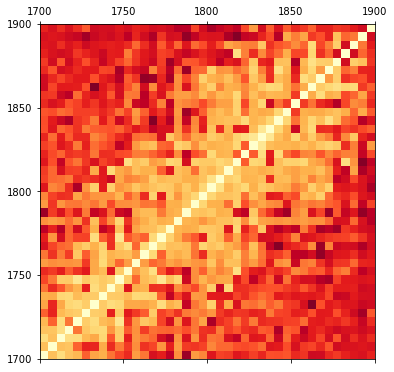

In [16]:
newmat = diagonal_permute(distdf.values)
plt.matshow(newmat, origin = 'lower', cmap = plt.cm.YlOrRd, extent = extent)
plt.show()

In [17]:
# novelties = foote_novelty(newmat)
# years = getyears()
# plt.plot(years, novelties)
# plt.show()
# print("Max novelty for five-year half-width:" + str(np.max(novelties)))

# def zeroless(sequence):
#     newseq = []
#     for element in sequence:
#         if element > 0.01:
#             newseq.append(element)
#     return newseq
# print("Min novelty for five-year half-width:" + str(np.min(zeroless(novelties))))

In [18]:

# novelties, significance, threshold01, threshold05, threshold95, threshold99 = permute_test(dq)
# years = getyears()
# plt.plot(years, novelties)
# startpoint = years[0]
# endpoint = years[-1]
# plt.hlines(threshold05, startpoint, endpoint, 'r', linewidth = 3)
# plt.hlines(threshold95, startpoint, endpoint, 'r', linewidth = 3)
# plt.show()

# # lc, x, y = colored_segments(novelties, significance)

# # plt.gca().add_collection(lc) # add the collection to the plot
# # plt.xlim(years[0], years[-1]) # line collections don't auto-scale the plot
# # plt.ylim(y.min(), y.max())
# # plt.show()

In [46]:
def test_novelty(distdf, foote_sizes=None, num_runs=100):
    if not foote_sizes: foote_sizes=range(FOOTE_W-3, FOOTE_W+2)
    dq=distdf.values
    o=[]
    for fs in foote_sizes:
        novelties, significance = permute_test(dq, foote_size=fs, num_runs=num_runs)
        for year,nov,sig in zip(distdf.columns, novelties, significance):
            odx={
                'year':year,
                'foote_novelty':nov,
                'foote_size':fs,
                'p':sig
            }
            o.append(odx)
    return pd.DataFrame(o).sort_values('foote_novelty',ascending=False)

In [47]:
%%timeit
test_novelty(distdf)

6.05 s ± 52.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
stop

NameError: name 'stop' is not defined

## Visualization

Neither of the methods used above are terribly good as visualizations, so let's come up with a slightly better version: getting rid of the misleading "edges" and overplotting points to indicate the number of significant observations in particular periods.

In [ ]:
def zeroless_seq(thefilter, filtereda, filteredb):
    thefilter = np.array(thefilter)
    filtereda = np.array(filtereda)
    filteredb = np.array(filteredb)
    filtereda = filtereda[thefilter > 0]
    filteredb = filteredb[thefilter > 0]
    thefilter = thefilter[thefilter > 0]
    return thefilter, filtereda, filteredb

plt.clf()
# plt.axis([1700, 1900, 45, 325])
novelties, significance, threshold01, threshold05, threshold95, threshold99 = permute_test(d.values)
novelties, years, significance = zeroless_seq(novelties, getyears(), significance)
yplot = novelties[significance < 0.05]
xplot = years[significance < 0.05]
plt.scatter(xplot, yplot, c = 'red')
plt.plot(years, novelties)
years = getyears()
startpoint = years[0]
endpoint = years[-1]
plt.hlines(threshold05, startpoint, endpoint, 'r', linewidth = 3)
plt.hlines(threshold95, startpoint, endpoint, 'r', linewidth = 3)
plt.show()

## Effect size

What about the effect size? Foote novelty is not really a direct measurement of the pace of change.

One way to measure it is, to accept the periods defined by the visualization above, and compare change across each of those periods. 

So, for instance, the significant points in the second peak range from 1990 to 1994, and the lowest trough is roughly 2001 to 2005. We can divide each of those periods in half, and compare the first half to the second half. It looks like Mauch et al. are roughly right about effect size: it's a sixfold difference.

In [ ]:
def pacechange(startdate, enddate, pca):
    years = getyears()
    startidx = years.index(startdate)
    endidx = years.index(enddate)
    midpoint = int((startidx + endidx)/2)
    firsthalf = np.zeros(len(years))
    for i in range(startidx,midpoint):
        firsthalf = firsthalf + pca[i]
    secondhalf = np.zeros(len(years))
    for i in range(midpoint, endidx):
        secondhalf = secondhalf + pca[i]
    return spatial.distance.cosine(firsthalf, secondhalf)

print(pacechange(1700, 1750, d.values))
print(pacechange(1750, 1800, d.values))
print(pacechange(1800, 1850, d.values))
print(pacechange(1850, 1890, d.values))


We can also get a mean value for the whole run.

In [ ]:
thesum = 0
theobservations = 0
for i in range(1700, 1890, 10):
    theobservations += 1
    thesum += pacechange(i, i+10, d.values)
print(thesum / theobservations)

## Comparing multiple scales at once

If we wanted to, we could also overplot multiple scales of comparison with different half-widths. Doing this reveals one of the nice things about the "Foote novelty" method, which is that it remains relatively stable as you vary scales of comparison. The same cannot be said, for instance, of changepoint analysis!

In the cell below we've overplotted three-year, four-year, and five-year Foote novelties, highlighting in each case the specific quarters that have two-tailed p values lower than 0.05.

In [ ]:
# plt.axis([1700, 1900, 0, y.max() + 10])
    
def add_scatter(d, width):
    novelties, significance, threshold01, threshold05, threshold95, threshold99 = permute_test(d, width)
    novelties, years, significance = zeroless_seq(novelties, getyears(), significance)
    yplot = novelties[significance < 0.05]
    xplot = years[significance < 0.05]
    plt.scatter(xplot, yplot, c = 'red')
    plt.plot(years, novelties)

ll=list(range(2,11))
for n in ll:
    add_scatter(d.values, n)
# add_scatter(d.values, 4)
# add_scatter(d.values, 5)
# add_scatter(d.values, 5)
plt.legend([str(n) for n in ll])
plt.ylabel('Foote novelty')
plt.show()